# Basic FAVA Functionality on Simulated Data

Suppose we collect data $D = \{(x^{(n)}, y^{(n)})\}^N_{n=1}$ with covariates $x^{(n)} \in \mathbb{R}^p$ and continuous scalar responses $y^{(n)}$. Suppose $y^{(n)} =  f^*(x^{(n)}) + \epsilon^{(n)}$, where $\epsilon^{(n)} \sim \mathcal{N}(0, \sigma^2)$, and the unknown regression function $f^*$ belongs to some class of functions $\mathcal{H}$. 


In this tutorial, we consider the setting where $\mathcal{H}$ contains the set of all linear main and interaction effects of order up to two, namely

$$\mathcal{H} := \left\{f: f = \beta_{\emptyset} + \sum_{i=1}^p \beta_{\{i\}} x_i + \sum_{i < j} \beta_{\{i, j\}} x_i x_j \quad \text{s.t.} \quad \beta_{V} \in \mathbb{R} \quad \forall V \subset \{1, \cdots, p\}, \ |V| \leq 2 \right\}. $$

We show how to:
 - Estimate $f^*$ by solving a penalized least squares problem of the form $\hat{f} = \arg \min_{f \in H} \sum_{n=1}^N (y^{(n)} - f(x^{(n)}))^2 + \lambda \|f\|_{\mathcal{H}}^2$ with SKIM-FA kernels
 - Recover estimates of each $\beta_V$
 - Perform an attribution analysis at both the covariate and individual datapoint level


## Tutorial Outline

 - [Setup](#Setup)
   - [Simulating Data](#Simulating-data)
   - [Splitting Data](#Split-data-into-training-and-validation)
 - [Fitting SKIM-FA Model](#Fit-SKIM-FA-Model)
 - [Assessing Quality of Fit](#Assessing-Quality-of-Fit)
   - [Predictive Performance vs. Random Forest](#Predictive-performance-vs.-random-forest)
   - [Estimated Effects](#Estimated-effects) 
 - [Model Interpretation](#Model-interpretation)
   - [Global Covariate Importance](#Global-covariate-importance)
   - [Single Datapoint Explanation](#Single-datapoint-explanation)

## Setup

We start by importing the required packages in `fava` and `jax`.

In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import jax

from fava.inference.fit import GaussianSKIMFA
from fava.basis.maps import LinearBasis
from fava.misc.scheduler import truncScheduler, constantScheduler
from fava.misc.logger import GausLogger
from fava.decomposers.decomposer import all_subsets
from fava.decomposers.tensor_product import TensorProductKernelANOVA, LinearANOVA
from fava.plots.waterfall import anova_waterfall
from fava.plots.sobol_indcs import sobol_importance

### Simulating data

Below we generate simulated data, where the covariates $x \in \mathbb{R}^{100}$ and $y \in \mathbb{R}$. We assume that the first 4 covariates drive the response $y$, and the remaining covariates have no influence on the response. Specifically, the $n$th datapoint is generated as follows: $y^{(n)} = x_1^{(n)}x_2^{(n)} + x_2^{(n)}x_3^{(n)} + \epsilon^{(n)}$, where $\epsilon^{(n)} \overset{\text{i.i.d.}}{\sim} \mathcal{N}(0, 1)$ for $1 \leq n \leq 500$.


In [2]:
key = random.PRNGKey(0) # set seed
N = 500
p = 100
X = random.normal(key, shape=(N, p))
epsilon = random.normal(key, shape=(N, ))
Y = X[:, 0] + X[:, 1] + X[:, 2] * X[:, 3] + epsilon

### Split data into training and validation

In [3]:
# Use 80% of the data for training and 20% for validation
X_train = X[:400, :]
Y_train = Y[:400]

X_valid = X[400:, :]
Y_valid = Y[400:]

## Fit SKIM-FA Model

Below we initialize SKIM-FA hyperparameters with default values. We run a total of $T=500$ iterations. The parameters that maximize predictive performance on the validation set are selected.

In [4]:
kernel_params = dict()
Q = 2
kernel_params['U_tilde'] = jnp.ones(p)
kernel_params['eta'] = jnp.ones(Q+1)

hyperparams = dict()
hyperparams['sigma_sq'] = .5 * jnp.var(Y)
hyperparams['c'] = .2

opt_params = dict()
opt_params['cg'] = True
opt_params['cg_tol'] = .01
opt_params['M'] = 100
opt_params['gamma'] = .1
opt_params['T'] = 500
opt_params['scheduler'] = constantScheduler() # we won't get exact sparsity since c is constant
featprocessor = LinearBasis(X_train)
logger = GausLogger(100)

skim = GaussianSKIMFA(X_train, Y_train, X_valid, Y_valid, featprocessor)

skim.fit(key, hyperparams, kernel_params, opt_params, 
            logger=GausLogger())

  0%|                                                                                                                 | 0/500 [00:00<?, ?it/s]

============================== Iteration 0/500 ==============================
There are 100 covariates selected.


  0%|▏                                                                                                        | 1/500 [00:04<36:16,  4.36s/it]

MSE (Validation)=2.5803.
R2 (Validation)=0.4308.
eta=[1.0000176  1.0927966  0.90706474]
c=0.2


 20%|████████████████████▌                                                                                  | 100/500 [00:41<02:26,  2.72it/s]

============================== Iteration 100/500 ==============================
There are 100 covariates selected.


 20%|████████████████████▊                                                                                  | 101/500 [00:41<03:01,  2.20it/s]

MSE (Validation)=1.3841.
R2 (Validation)=0.6947.
eta=[0.9999887 1.3747737 0.9144955]
c=0.2


 40%|█████████████████████████████████████████▏                                                             | 200/500 [01:19<01:53,  2.65it/s]

============================== Iteration 200/500 ==============================
There are 100 covariates selected.


 40%|█████████████████████████████████████████▍                                                             | 201/500 [01:19<02:21,  2.11it/s]

MSE (Validation)=1.4887.
R2 (Validation)=0.6716.
eta=[1.0004566 1.4380944 1.1376388]
c=0.2


 60%|█████████████████████████████████████████████████████████████▊                                         | 300/500 [01:57<01:15,  2.63it/s]

============================== Iteration 300/500 ==============================
There are 100 covariates selected.


 60%|██████████████████████████████████████████████████████████████                                         | 301/500 [01:58<01:33,  2.14it/s]

MSE (Validation)=1.7322.
R2 (Validation)=0.6179.
eta=[1.0039895 1.5636828 1.2282599]
c=0.2


 80%|██████████████████████████████████████████████████████████████████████████████████▍                    | 400/500 [02:35<00:37,  2.65it/s]

============================== Iteration 400/500 ==============================
There are 100 covariates selected.


 80%|██████████████████████████████████████████████████████████████████████████████████▌                    | 401/500 [02:36<00:45,  2.16it/s]

MSE (Validation)=2.0149.
R2 (Validation)=0.5555.
eta=[1.0111151 1.7499819 1.2703197]
c=0.2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:13<00:00,  2.58it/s]


## Assessing Quality of Fit

### Predictive performance vs. random forest

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import numpy as np

In [6]:
rf = RandomForestRegressor(n_estimators=1000, random_state=0)
rf.fit(np.array(X), np.array(Y))

RandomForestRegressor(n_estimators=1000, random_state=0)

In [7]:
# Generate new test set and compare R^2 performance
N_test = 1000
X_test = random.normal(key, shape=(N_test, p))
epsilon = random.normal(key, shape=(N_test, ))
Y_test = X_test[:, 0] + X_test[:, 1] + X_test[:, 2] * X_test[:, 3] + epsilon

In [8]:
rf_r2 = rf.score(np.array(X_test), np.array(Y_test))
skimfa_r2 = r2_score(Y_test, skim.predict(X_test))

In [9]:
print(f'Random Forest Test R^2: {round(rf_r2, 4)}')
print(f'SKIM-FA Test R^2: {round(skimfa_r2, 4)}')

Random Forest Test R^2: 0.4495
SKIM-FA Test R^2: 0.6038


### Estimated effects

Now we compute all of the main/interaction effects found by SKIM-FA. Since we fit a linear interaction model, we report the regression coefficients associated with each effect. Since we used a constant scheduler for c, we do not get exact sparsity.

In [10]:
# Compute all main and in
lanova = LinearANOVA(skim)
V_all = all_subsets(skim.selected_covariates(), 2, True)
all_skim_effects = dict()
for V in V_all:
    all_skim_effects[V] = lanova.get_coef(V)

In [11]:
# Report Top 5 positive effects found
top5_positive = sorted(all_skim_effects, key=all_skim_effects.get, reverse=True)[:5]
top5_negative = sorted(all_skim_effects, key=all_skim_effects.get, reverse=False)[:5]

print('Top 5 Strongest Positive Effects Found:')
for V in top5_positive:
    print(V,  round(all_skim_effects[V], 3))

Top 5 Strongest Positive Effects Found:
(1,) 0.923
(0,) 0.861
(2, 3) 0.739
(65,) 0.109
(30,) 0.105


In [12]:
print('Top 5 Strongest Negative Effects Found:')
for V in top5_negative:
    print(V,  round(all_skim_effects[V], 3))

Top 5 Strongest Negative Effects Found:
(2,) -0.107
(52,) -0.091
(2, 21) -0.089
(83,) -0.088
(70,) -0.086


In [13]:
Y_test_pred = skim.predict(X_test)
variation_intercept = lanova.get_variation_at_order(X_test, 0)
variation_additive = lanova.get_variation_at_order(X_test, 1)
variation_pairwise = lanova.get_variation_at_order(X_test, 2)

In [14]:
# The sum of the variation at each order recovers the prediction output
check = variation_intercept + variation_additive + variation_pairwise
assert jnp.abs(Y_test_pred - check).max() < 1e-5

## Model interpretation

### Global covariate importance

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.91it/s]


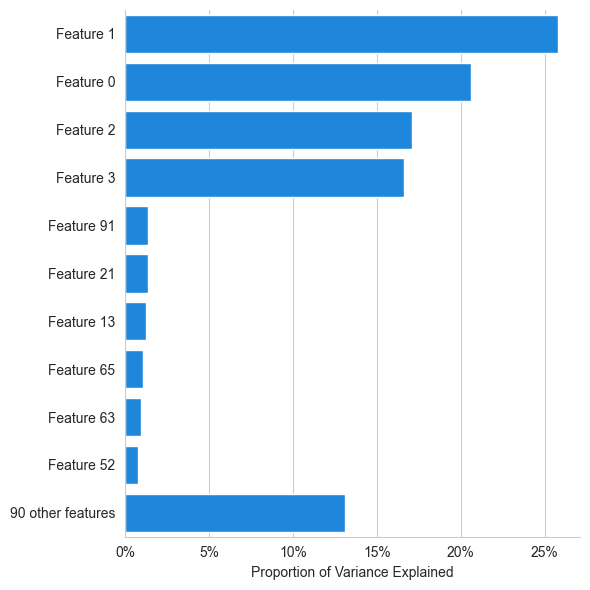

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
covariate_importance = sobol_importance(X_train, lanova, ax)

### Single datapoint explanation

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 5051/5051 [00:28<00:00, 177.25it/s]


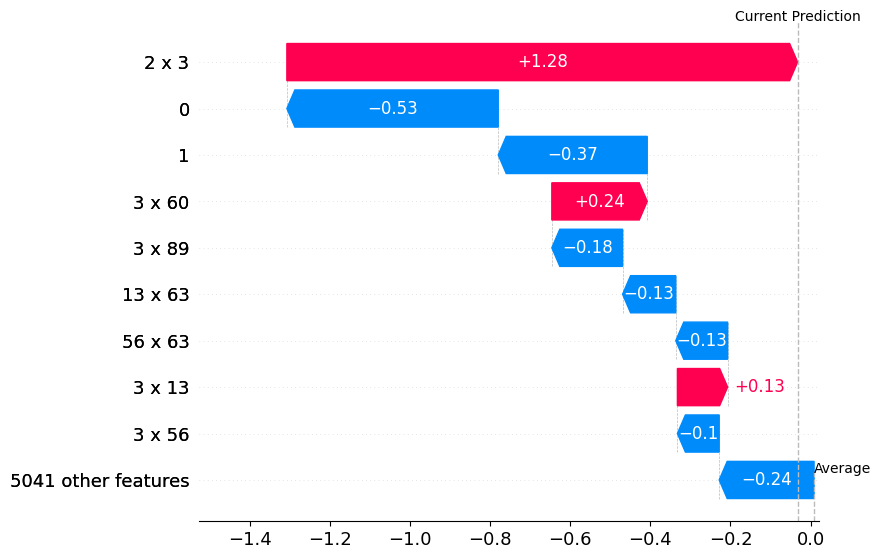

In [16]:
# Prediction attribution breakdown for first test datapoint
anova_waterfall(X_test[0,:], lanova, [str(i) for i in range(p)])